# Mobile sensing Lab 2 - Python framework for data processing - Part 2 (Data science)
We will develop a machine learning pipeline for activity recognition from smartphone sensor data (acceleration, gravity, etc.). The first part of the pipeline contains:

1. Exploratory data analysis - check data quality and calculate informative statistics about the dataset;
2. Segmentation and filtering - segment the data into windows (e.g., 4 seconds data) and try different filtering methods to improve the sensor data quality i.e., remove noise;

The second part of the pipeline contains:
3. Feature extraction and visualization - calculate features for each segment, which will be used as input to machine learning models;
4. Building and evaluation of machine learning models.

## 1. Import data

The dataset that we are going to use is downloaded form: https://github.com/mmalekzadeh/motion-sense.

The dataset includes raw data from 4 sensors, 3-axis per sensor, thus 4x3 = 12 time-series. More specifically, the sensors are:
1. Orientation sensor - measures degrees of rotation that a device makes around all three physical axes x, y, z (roll, pitch, yaw);
2. Gravity sensor - measures the force of gravity in m/s2 that is applied to a device on all three physical axes x, y and z; 
3. Accelerometer - measures the acceleration force in m/s2 that is applied to a device on all three physical axes x, y, and z, including the force of gravity;
4. Gyroscope sensors - measures a device's rate of rotation in rad/s around each of the three physical axes x, y, and z. 
    
  
The dataset is collected with an iPhone 6s kept in the participant's front pocket. All data is collected in 50Hz sample rate. A total of 24 participants in a range of gender, age, weight, and height performed 6 activities in 15 trials in the same environment and conditions: downstairs, upstairs, walking, jogging, sitting, and standing. 

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
import seaborn as sns

In [8]:
#import the data
data_path = os.getcwd()+"/data/motion-sense-processed.csv"
print("Loading data from:",data_path)
data = pd.read_csv(data_path,header=0,index_col =0)
print("Done. Loaded data frame (rows, columns):",data.shape, "")
data

Loading data from: /Users/erikjanezic/Documents/Faculty/arp/labs2/data/motion-sense-processed.csv
Done. Loaded data frame (rows, columns): (1412865, 19) 


,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id,weight,height,age,gender,trial
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,0.0,0.0,102.0,188.0,46.0,1.0,1.0
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,0.0,0.0,102.0,188.0,46.0,1.0,1.0
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,0.0,0.0,102.0,188.0,46.0,1.0,1.0
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,0.0,0.0,102.0,188.0,46.0,1.0,1.0
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,0.0,0.0,102.0,188.0,46.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1412860,-2.368280,-0.381075,-0.089417,-0.648402,0.371919,0.664267,-0.001312,-0.011512,0.001284,0.000789,-0.005937,-0.004355,5.0,23.0,74.0,173.0,18.0,0.0,13.0
1412861,-2.368752,-0.381071,-0.089478,-0.648090,0.371915,0.664574,-0.000293,-0.022169,0.001305,-0.000409,-0.000608,0.000098,5.0,23.0,74.0,173.0,18.0,0.0,13.0
1412862,-2.369130,-0.381163,-0.089465,-0.647814,0.372000,0.664795,0.007208,-0.012616,0.003482,-0.000486,0.000711,0.002045,5.0,23.0,74.0,173.0,18.0,0.0,13.0
1412863,-2.369372,-0.381295,-0.089468,-0.647619,0.372123,0.664916,0.006180,-0.003029,0.004531,0.000311,-0.003395,0.004746,5.0,23.0,74.0,173.0,18.0,0.0,13.0


In [21]:
data.columns[:12]

Index(['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'gravity.x',
       'gravity.y', 'gravity.z', 'rotationRate.x', 'rotationRate.y',
       'rotationRate.z', 'userAcceleration.x', 'userAcceleration.y',
       'userAcceleration.z'],
      dtype='object')

## 3. Feature extraction and visualization

1. Create a function "segment_filter_extract" for signal segmentation, filtering and feature extraction.
2. Extract features and check for NULL values
3. Visualize the distribution of each feature using hisotgrams
4. Visualize the distribution of each feature using boxplots
5. Normalize the features and repeat the visualization

In [9]:
def low_pass_filter(segment):
    fs = 50  # Sampling frequency
    fc = 5  # Cut-off frequency of the filter
    w = fc / (fs / 2) # Normalize the frequency
    n= 5 #The order of the filter.
    b, a = signal.butter(n, w, 'low')
    output = signal.filtfilt(b, a, segment)
    return output

sensor_columns = sensor_columns = data.columns[:12]
stat_feature_names = ['window_counter','moment1','moment2','moment3','moment4',
                      'derivative1','derivative2',
                      'quartile25','quartile75','quartileDeviaton',
                      'min_max','variation_coeff']

#min-max: Difference between min and max of the signal

#the function takes as input a segment
#and calcualtes a list of statistical features
#the function returns a list of the extracted features

def get_statistical_features(arr):
    arr =  pd.Series(arr)
    r = [arr.mean(),arr.std(),arr.skew(),arr.kurtosis(),arr.diff().mean(),
         arr.diff().diff().mean(),arr.quantile(0.25),arr.quantile(0.75),
         arr.quantile(0.75)-arr.quantile(0.25),arr.max()-arr.min()]
    if(arr.std()!=0): #avoid 0 division
        r.append(arr.mean()/arr.std())
    else:
         r.append(0.0)
    return np.hstack(r)

#the function takes as input a 1-D sifnal of a trial (pandas timeseries) 
#and the size of the window (default 4 seconds)to be used for the segmentation
#the function filters the signal, extracts features 
#and returns a list of segments represented via the features, 
#where the first "feature" is the segment's order number in the trial
def segment_filter_extract(trial, window_size=4*50):
    trial_f  = low_pass_filter(trial.values) 
    #segment the data
    win_start = 0
    win_end = win_start+window_size
    features_arr = []
    segment_counter = 0
    while win_end<len(trial_f):
        segment = trial_f[win_start:win_end]
        segment_features = get_statistical_features(segment)
        segment_features = np.concatenate(([segment_counter],segment_features))
        features_arr.append(segment_features)
        #move/slide the window
        win_start = win_end
        win_end = win_start+window_size
        segment_counter = segment_counter+1
    return features_arr

#iterate through the data of each participant and each trial 
#and perform segmentation, filtering and feature extraction
all_features = []
for participant in data.id.unique():
    data_p = data[data.id==participant] #get the data of the specific participant
    print("Segmenting data for participant:", participant)
    print("Data shape:", data_p.shape)
    participant_features = []
    for trial in data_p.trial.unique():
        data_p_t = data_p[data_p.trial==trial] #get the data of the specific participant's trial
        trial_label = data_p_t.act.median()
        print("Trial data shape:", data_p_t.shape)
        trial_features = []
        for sensor_axis in sensor_columns: #for each sensor axis perform: segmentation, filtering and feature extraction
            print(participant,trial,"Segmenting sensor-axis:", sensor_axis)
            axis_features = segment_filter_extract(data_p_t[sensor_axis]) 
            print("Number of segments,features:", np.array(axis_features).shape)
            trial_features.append(axis_features)
        trial_features = np.concatenate(trial_features,axis=1) #rows represent segments, columns represent features
        print('trial_features shape',trial_features.shape)
        trial_info = [[participant,trial,trial_label]]*len(trial_features) #for each segment crate info columns
        trial_features = np.column_stack((trial_info,trial_features)) #add info columns
        participant_features.append(trial_features)
        print('-')
    participant_features = np.concatenate(participant_features)
    print('participant_features shape',participant_features.shape)
    all_features.append(participant_features)
    print('---------')

print('DONE')
all_features= np.concatenate(all_features)
print(all_features.shape)

Segmenting data for participant: 0.0
Data shape: (62312, 19)
Trial data shape: (1751, 19)
0.0 1.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (8, 12)
0.0 1.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (8, 12)
0.0 1.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (8, 12)
0.0 1.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (8, 12)
0.0 1.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (8, 12)
0.0 1.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (8, 12)
0.0 1.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (8, 12)
0.0 1.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (8, 12)
0.0 1.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (8, 12)
0.0 1.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (8, 12)
0.0 1.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (8, 

Number of segments,features: (21, 12)
0.0 8.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (21, 12)
0.0 8.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (21, 12)
0.0 8.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (21, 12)
0.0 8.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (21, 12)
trial_features shape (21, 144)
-
Trial data shape: (1333, 19)
0.0 15.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (6, 12)
0.0 15.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (6, 12)
0.0 15.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (6, 12)
0.0 15.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (6, 12)
0.0 15.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (6, 12)
0.0 15.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (6, 12)
0.0 15.0 Segmenting sensor-axis: rotationRate.x
Number o

Number of segments,features: (10, 12)
1.0 1.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (10, 12)
1.0 1.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (10, 12)
1.0 1.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (10, 12)
1.0 1.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (10, 12)
1.0 1.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (10, 12)
trial_features shape (10, 144)
-
Trial data shape: (2639, 19)
1.0 2.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (13, 12)
1.0 2.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (13, 12)
1.0 2.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (13, 12)
1.0 2.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (13, 12)
1.0 2.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (13, 12)
1.0 2.0 Segmenting sensor-axis: gravity.z
Number of

Number of segments,features: (31, 12)
1.0 15.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (31, 12)
1.0 15.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (31, 12)
1.0 15.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (31, 12)
1.0 15.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (31, 12)
1.0 15.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (31, 12)
1.0 15.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (31, 12)
1.0 15.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (31, 12)
1.0 15.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (31, 12)
1.0 15.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (31, 12)
1.0 15.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (31, 12)
trial_features shape (31, 144)
-
Trial data shape: (4966, 19)
1.0 9.0 Segmenting sensor-axis: attitude.roll

Number of segments,features: (14, 12)
2.0 2.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (14, 12)
2.0 2.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (14, 12)
2.0 2.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (14, 12)
2.0 2.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (14, 12)
2.0 2.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (14, 12)
2.0 2.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (14, 12)
2.0 2.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (14, 12)
2.0 2.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (14, 12)
2.0 2.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (14, 12)
2.0 2.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (14, 12)
2.0 2.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (14, 12)
trial_features shape (14, 144)
-

Number of segments,features: (17, 12)
2.0 15.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (17, 12)
trial_features shape (17, 144)
-
Trial data shape: (4753, 19)
2.0 9.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (23, 12)
2.0 9.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (23, 12)
2.0 9.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (23, 12)
2.0 9.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (23, 12)
2.0 9.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (23, 12)
2.0 9.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (23, 12)
2.0 9.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (23, 12)
2.0 9.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (23, 12)
2.0 9.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (23, 12)
2.0 9.0 Segmenting sensor-axis: userAcceleration.x
Number of se

Number of segments,features: (11, 12)
3.0 2.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (11, 12)
3.0 2.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (11, 12)
3.0 2.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (11, 12)
3.0 2.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (11, 12)
3.0 2.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (11, 12)
3.0 2.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (11, 12)
trial_features shape (11, 144)
-
Trial data shape: (925, 19)
3.0 11.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (4, 12)
3.0 11.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (4, 12)
3.0 11.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (4, 12)
3.0 11.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (4, 12)
3.0 11.0 Segmenting sensor-axis: gravity.y
Numb

Number of segments,features: (26, 12)
3.0 9.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (26, 12)
3.0 9.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (26, 12)
3.0 9.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (26, 12)
3.0 9.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (26, 12)
3.0 9.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (26, 12)
3.0 9.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (26, 12)
3.0 9.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (26, 12)
3.0 9.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (26, 12)
3.0 9.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (26, 12)
3.0 9.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (26, 12)
3.0 9.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (26, 12)
trial_features shape (26, 144)
-

Number of segments,features: (10, 12)
4.0 2.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (10, 12)
trial_features shape (10, 144)
-
Trial data shape: (699, 19)
4.0 11.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (3, 12)
4.0 11.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (3, 12)
4.0 11.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (3, 12)
4.0 11.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (3, 12)
4.0 11.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (3, 12)
4.0 11.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (3, 12)
4.0 11.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (3, 12)
4.0 11.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (3, 12)
4.0 11.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (3, 12)
4.0 11.0 Segmenting sensor-axis: userAcceleration.x
Number of seg

Number of segments,features: (17, 12)
4.0 9.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (17, 12)
4.0 9.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (17, 12)
4.0 9.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (17, 12)
trial_features shape (17, 144)
-
Trial data shape: (765, 19)
4.0 16.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (3, 12)
4.0 16.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (3, 12)
4.0 16.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (3, 12)
4.0 16.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (3, 12)
4.0 16.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (3, 12)
4.0 16.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (3, 12)
4.0 16.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (3, 12)
4.0 16.0 Segmenting sensor-axis: rotationRate.y
Number of

Number of segments,features: (5, 12)
5.0 11.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (5, 12)
5.0 11.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (5, 12)
5.0 11.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (5, 12)
trial_features shape (5, 144)
-
Trial data shape: (1957, 19)
5.0 3.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (9, 12)
5.0 3.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (9, 12)
5.0 3.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (9, 12)
5.0 3.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (9, 12)
5.0 3.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (9, 12)
5.0 3.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (9, 12)
5.0 3.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (9, 12)
5.0 3.0 Segmenting sensor-axis: rotationRate.y
Number of segments

Number of segments,features: (4, 12)
trial_features shape (4, 144)
-
Trial data shape: (8767, 19)
5.0 6.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (43, 12)
5.0 6.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (43, 12)
5.0 6.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (43, 12)
5.0 6.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (43, 12)
5.0 6.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (43, 12)
5.0 6.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (43, 12)
5.0 6.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (43, 12)
5.0 6.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (43, 12)
5.0 6.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (43, 12)
5.0 6.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (43, 12)
5.0 6.0 Segmenting sensor-axis: userAcceleration.y
Number of segme

Number of segments,features: (13, 12)
6.0 3.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (13, 12)
6.0 3.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (13, 12)
6.0 3.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (13, 12)
6.0 3.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (13, 12)
6.0 3.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (13, 12)
6.0 3.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (13, 12)
trial_features shape (13, 144)
-
Trial data shape: (3304, 19)
6.0 4.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (16, 12)
6.0 4.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (16, 12)
6.0 4.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (16, 12)
6.0 4.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (16, 12)
6.0 4.0 Segmenting sensor-axis: gravity.y
Numb

Number of segments,features: (46, 12)
6.0 6.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (46, 12)
6.0 6.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (46, 12)
6.0 6.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (46, 12)
6.0 6.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (46, 12)
6.0 6.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (46, 12)
6.0 6.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (46, 12)
6.0 6.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (46, 12)
6.0 6.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (46, 12)
6.0 6.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (46, 12)
6.0 6.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (46, 12)
trial_features shape (46, 144)
-
Trial data shape: (2655, 19)
6.0 14.0 Segmenting sensor-axis: attitude.roll
Number o

Number of segments,features: (14, 12)
7.0 3.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (14, 12)
7.0 3.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (14, 12)
7.0 3.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (14, 12)
trial_features shape (14, 144)
-
Trial data shape: (2991, 19)
7.0 4.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (14, 12)
7.0 4.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (14, 12)
7.0 4.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (14, 12)
7.0 4.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (14, 12)
7.0 4.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (14, 12)
7.0 4.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (14, 12)
7.0 4.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (14, 12)
7.0 4.0 Segmenting sensor-axis: rotationRate.y
Number of

Number of segments,features: (52, 12)
7.0 6.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (52, 12)
7.0 6.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (52, 12)
7.0 6.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (52, 12)
7.0 6.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (52, 12)
7.0 6.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (52, 12)
7.0 6.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (52, 12)
7.0 6.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (52, 12)
trial_features shape (52, 144)
-
Trial data shape: (3106, 19)
7.0 14.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (15, 12)
7.0 14.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (15, 12)
7.0 14.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (15, 12)
7.0 14.0 Segmenting sensor-axis: gravity.x


Number of segments,features: (14, 12)
8.0 4.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (14, 12)
8.0 4.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (14, 12)
8.0 4.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (14, 12)
8.0 4.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (14, 12)
8.0 4.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (14, 12)
8.0 4.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (14, 12)
8.0 4.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (14, 12)
8.0 4.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (14, 12)
8.0 4.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (14, 12)
trial_features shape (14, 144)
-
Trial data shape: (1183, 19)
8.0 12.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (5, 12)
8.0 12.0 Segmenting sensor-axis: attitude.pitch
Number

Number of segments,features: (38, 12)
8.0 6.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (38, 12)
trial_features shape (38, 144)
-
Trial data shape: (2161, 19)
8.0 14.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (10, 12)
8.0 14.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (10, 12)
8.0 14.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (10, 12)
8.0 14.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (10, 12)
8.0 14.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (10, 12)
8.0 14.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (10, 12)
8.0 14.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (10, 12)
8.0 14.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (10, 12)
8.0 14.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (10, 12)
8.0 14.0 Segmenting sensor-axis: userAcceleration.x
Num

Number of segments,features: (14, 12)
9.0 4.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (14, 12)
9.0 4.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (14, 12)
9.0 4.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (14, 12)
9.0 4.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (14, 12)
9.0 4.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (14, 12)
9.0 4.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (14, 12)
9.0 4.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (14, 12)
trial_features shape (14, 144)
-
Trial data shape: (1326, 19)
9.0 12.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (6, 12)
9.0 12.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (6, 12)
9.0 12.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (6, 12)
9.0 12.0 Segmenting sensor-axis: gravity.x
Num

Number of segments,features: (16, 12)
9.0 14.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (16, 12)
9.0 14.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (16, 12)
9.0 14.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (16, 12)
9.0 14.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (16, 12)
9.0 14.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (16, 12)
9.0 14.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (16, 12)
9.0 14.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (16, 12)
trial_features shape (16, 144)
-
Trial data shape: (9397, 19)
9.0 5.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (46, 12)
9.0 5.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (46, 12)
9.0 5.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (46, 12)
9.0 5.0 Segmenting sensor-axis: gravity

Number of segments,features: (13, 12)
trial_features shape (13, 144)
-
Trial data shape: (1149, 19)
10.0 12.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (5, 12)
10.0 12.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (5, 12)
10.0 12.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (5, 12)
10.0 12.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (5, 12)
10.0 12.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (5, 12)
10.0 12.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (5, 12)
10.0 12.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (5, 12)
10.0 12.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (5, 12)
10.0 12.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (5, 12)
10.0 12.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (5, 12)
10.0 12.0 Segmenting sensor-axis: userAcceleration.y
N

Number of segments,features: (14, 12)
10.0 14.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (14, 12)
10.0 14.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (14, 12)
10.0 14.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (14, 12)
10.0 14.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (14, 12)
trial_features shape (14, 144)
-
Trial data shape: (7926, 19)
10.0 5.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (39, 12)
10.0 5.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (39, 12)
10.0 5.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (39, 12)
10.0 5.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (39, 12)
10.0 5.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (39, 12)
10.0 5.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (39, 12)
10.0 5.0 Segmenting sensor-axis: rotationR

Number of segments,features: (7, 12)
11.0 12.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (7, 12)
trial_features shape (7, 144)
-
Trial data shape: (6742, 19)
11.0 7.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (33, 12)
11.0 7.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (33, 12)
11.0 7.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (33, 12)
11.0 7.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (33, 12)
11.0 7.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (33, 12)
11.0 7.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (33, 12)
11.0 7.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (33, 12)
11.0 7.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (33, 12)
11.0 7.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (33, 12)
11.0 7.0 Segmenting sensor-axis: userAcceleration.x
Numb

Number of segments,features: (40, 12)
11.0 5.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (40, 12)
11.0 5.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (40, 12)
11.0 5.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (40, 12)
11.0 5.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (40, 12)
11.0 5.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (40, 12)
11.0 5.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (40, 12)
11.0 5.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (40, 12)
trial_features shape (40, 144)
-
Trial data shape: (2934, 19)
11.0 13.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (14, 12)
11.0 13.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (14, 12)
11.0 13.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (14, 12)
11.0 13.0 Segmenting sensor-axis:

Number of segments,features: (27, 12)
12.0 7.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (27, 12)
12.0 7.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (27, 12)
12.0 7.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (27, 12)
12.0 7.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (27, 12)
12.0 7.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (27, 12)
12.0 7.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (27, 12)
12.0 7.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (27, 12)
12.0 7.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (27, 12)
12.0 7.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (27, 12)
12.0 7.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (27, 12)
trial_features shape (27, 144)
-
Trial data shape: (3782, 19)
12.0 8.0 Segmenting sensor-axis: attitude.rol

Number of segments,features: (49, 12)
12.0 5.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (49, 12)
12.0 5.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (49, 12)
12.0 5.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (49, 12)
trial_features shape (49, 144)
-
Trial data shape: (3274, 19)
12.0 13.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (16, 12)
12.0 13.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (16, 12)
12.0 13.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (16, 12)
12.0 13.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (16, 12)
12.0 13.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (16, 12)
12.0 13.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (16, 12)
12.0 13.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (16, 12)
12.0 13.0 Segmenting sensor-axis: rotat

Number of segments,features: (33, 12)
13.0 7.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (33, 12)
13.0 7.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (33, 12)
13.0 7.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (33, 12)
13.0 7.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (33, 12)
13.0 7.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (33, 12)
13.0 7.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (33, 12)
13.0 7.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (33, 12)
13.0 7.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (33, 12)
13.0 7.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (33, 12)
trial_features shape (33, 144)
-
Trial data shape: (4695, 19)
13.0 8.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (23, 12)
13.0 8.0 Segmenting sensor-axis: attitude.pi

Number of segments,features: (63, 12)
13.0 5.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (63, 12)
trial_features shape (63, 144)
-
Trial data shape: (2928, 19)
13.0 13.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (14, 12)
13.0 13.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (14, 12)
13.0 13.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (14, 12)
13.0 13.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (14, 12)
13.0 13.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (14, 12)
13.0 13.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (14, 12)
13.0 13.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (14, 12)
13.0 13.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (14, 12)
13.0 13.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (14, 12)
13.0 13.0 Segmenting sensor-axis: userAcceler

Number of segments,features: (34, 12)
14.0 7.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (34, 12)
14.0 7.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (34, 12)
14.0 7.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (34, 12)
14.0 7.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (34, 12)
14.0 7.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (34, 12)
14.0 7.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (34, 12)
14.0 7.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (34, 12)
trial_features shape (34, 144)
-
Trial data shape: (4906, 19)
14.0 8.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (24, 12)
14.0 8.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (24, 12)
14.0 8.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (24, 12)
14.0 8.0 Segmenting sensor-axis: gra

Number of segments,features: (29, 12)
14.0 13.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (29, 12)
14.0 13.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (29, 12)
14.0 13.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (29, 12)
14.0 13.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (29, 12)
14.0 13.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (29, 12)
14.0 13.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (29, 12)
14.0 13.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (29, 12)
14.0 13.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (29, 12)
14.0 13.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (29, 12)
14.0 13.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (29, 12)
14.0 13.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (29, 12)
trial_feat

Number of segments,features: (36, 12)
15.0 7.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (36, 12)
15.0 7.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (36, 12)
15.0 7.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (36, 12)
15.0 7.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (36, 12)
15.0 7.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (36, 12)
trial_features shape (36, 144)
-
Trial data shape: (5446, 19)
15.0 8.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (27, 12)
15.0 8.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (27, 12)
15.0 8.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (27, 12)
15.0 8.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (27, 12)
15.0 8.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (27, 12)
15.0 8.0 Segmenting sensor-axis: gravity.

Number of segments,features: (21, 12)
15.0 13.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (21, 12)
15.0 13.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (21, 12)
15.0 13.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (21, 12)
15.0 13.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (21, 12)
15.0 13.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (21, 12)
15.0 13.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (21, 12)
15.0 13.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (21, 12)
15.0 13.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (21, 12)
trial_features shape (21, 144)
-
participant_features shape (321, 147)
---------
Segmenting data for participant: 16.0
Data shape: (55539, 19)
Trial data shape: (2085, 19)
16.0 1.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (10, 12)
16.0 1.

Number of segments,features: (34, 12)
16.0 7.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (34, 12)
trial_features shape (34, 144)
-
Trial data shape: (4665, 19)
16.0 8.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (23, 12)
16.0 8.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (23, 12)
16.0 8.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (23, 12)
16.0 8.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (23, 12)
16.0 8.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (23, 12)
16.0 8.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (23, 12)
16.0 8.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (23, 12)
16.0 8.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (23, 12)
16.0 8.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (23, 12)
16.0 8.0 Segmenting sensor-axis: userAcceleration.x
Nu

Number of segments,features: (15, 12)
16.0 13.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (15, 12)
16.0 13.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (15, 12)
16.0 13.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (15, 12)
16.0 13.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (15, 12)
16.0 13.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (15, 12)
trial_features shape (15, 144)
-
participant_features shape (270, 147)
---------
Segmenting data for participant: 17.0
Data shape: (62808, 19)
Trial data shape: (2946, 19)
17.0 1.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (14, 12)
17.0 1.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (14, 12)
17.0 1.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (14, 12)
17.0 1.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (14, 12)
17.0 1.

Number of segments,features: (29, 12)
17.0 8.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (29, 12)
17.0 8.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (29, 12)
17.0 8.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (29, 12)
17.0 8.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (29, 12)
17.0 8.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (29, 12)
17.0 8.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (29, 12)
17.0 8.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (29, 12)
17.0 8.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (29, 12)
17.0 8.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (29, 12)
trial_features shape (29, 144)
-
Trial data shape: (2388, 19)
17.0 15.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (11, 12)
17.0 15.0 Segmenting sensor-axis: attitude.

Number of segments,features: (22, 12)
17.0 13.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (22, 12)
17.0 13.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (22, 12)
trial_features shape (22, 144)
-
participant_features shape (306, 147)
---------
Segmenting data for participant: 18.0
Data shape: (71949, 19)
Trial data shape: (2048, 19)
18.0 1.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (10, 12)
18.0 1.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (10, 12)
18.0 1.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (10, 12)
18.0 1.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (10, 12)
18.0 1.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (10, 12)
18.0 1.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (10, 12)
18.0 1.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (10, 12)
18.0 1.0 Segmenting sens

Number of segments,features: (26, 12)
18.0 8.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (26, 12)
18.0 8.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (26, 12)
18.0 8.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (26, 12)
18.0 8.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (26, 12)
18.0 8.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (26, 12)
18.0 8.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (26, 12)
18.0 8.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (26, 12)
18.0 8.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (26, 12)
18.0 8.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (26, 12)
trial_features shape (26, 144)
-
Trial data shape: (3227, 19)
18.0 15.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (16, 12)
18.0 15.0 Segmenting sensor-axis: attitude.

Number of segments,features: (24, 12)
trial_features shape (24, 144)
-
participant_features shape (354, 147)
---------
Segmenting data for participant: 19.0
Data shape: (55153, 19)
Trial data shape: (2236, 19)
19.0 1.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (11, 12)
19.0 1.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (11, 12)
19.0 1.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (11, 12)
19.0 1.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (11, 12)
19.0 1.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (11, 12)
19.0 1.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (11, 12)
19.0 1.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (11, 12)
19.0 1.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (11, 12)
19.0 1.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (11, 12)
19.0 1.0 Segmenting sensor-axis: u

Number of segments,features: (25, 12)
19.0 8.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (25, 12)
19.0 8.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (25, 12)
19.0 8.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (25, 12)
19.0 8.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (25, 12)
19.0 8.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (25, 12)
trial_features shape (25, 144)
-
Trial data shape: (2861, 19)
19.0 15.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (14, 12)
19.0 15.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (14, 12)
19.0 15.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (14, 12)
19.0 15.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (14, 12)
19.0 15.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (14, 12)
19.0 15.0 Segmenting sensor-axis: gr

Segmenting data for participant: 20.0
Data shape: (68932, 19)
Trial data shape: (2905, 19)
20.0 1.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (14, 12)
20.0 1.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (14, 12)
20.0 1.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (14, 12)
20.0 1.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (14, 12)
20.0 1.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (14, 12)
20.0 1.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (14, 12)
20.0 1.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (14, 12)
20.0 1.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (14, 12)
20.0 1.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (14, 12)
20.0 1.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (14, 12)
20.0 1.0 Segmenting sensor-axis: userAcceleration.y
Number of s

Number of segments,features: (31, 12)
20.0 8.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (31, 12)
20.0 8.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (31, 12)
20.0 8.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (31, 12)
20.0 8.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (31, 12)
20.0 8.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (31, 12)
trial_features shape (31, 144)
-
Trial data shape: (3192, 19)
20.0 15.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (15, 12)
20.0 15.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (15, 12)
20.0 15.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (15, 12)
20.0 15.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (15, 12)
20.0 15.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (15, 12)
20.0 15.0 Segmenting sensor-axis: gr

Number of segments,features: (9, 12)
21.0 1.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (9, 12)
21.0 1.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (9, 12)
21.0 1.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (9, 12)
21.0 1.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (9, 12)
21.0 1.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (9, 12)
21.0 1.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (9, 12)
21.0 1.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (9, 12)
21.0 1.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (9, 12)
trial_features shape (9, 144)
-
Trial data shape: (1920, 19)
21.0 2.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (9, 12)
21.0 2.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (9, 12)
21.0 2.0 Segmenting sensor-axis: attitude.yaw
Numbe

Number of segments,features: (24, 12)
trial_features shape (24, 144)
-
Trial data shape: (2373, 19)
21.0 15.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (11, 12)
21.0 15.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (11, 12)
21.0 15.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (11, 12)
21.0 15.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (11, 12)
21.0 15.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (11, 12)
21.0 15.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (11, 12)
21.0 15.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (11, 12)
21.0 15.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (11, 12)
21.0 15.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (11, 12)
21.0 15.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (11, 12)
21.0 15.0 Segmenting sensor-axis: userAccele

Number of segments,features: (11, 12)
22.0 1.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (11, 12)
trial_features shape (11, 144)
-
Trial data shape: (2832, 19)
22.0 2.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (14, 12)
22.0 2.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (14, 12)
22.0 2.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (14, 12)
22.0 2.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (14, 12)
22.0 2.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (14, 12)
22.0 2.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (14, 12)
22.0 2.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (14, 12)
22.0 2.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (14, 12)
22.0 2.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (14, 12)
22.0 2.0 Segmenting sensor-axis: userAcceleration.x
Nu

Number of segments,features: (16, 12)
22.0 15.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (16, 12)
22.0 15.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (16, 12)
22.0 15.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (16, 12)
22.0 15.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (16, 12)
22.0 15.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (16, 12)
trial_features shape (16, 144)
-
Trial data shape: (4815, 19)
22.0 9.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (24, 12)
22.0 9.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (24, 12)
22.0 9.0 Segmenting sensor-axis: attitude.yaw
Number of segments,features: (24, 12)
22.0 9.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (24, 12)
22.0 9.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (24, 12)
22.0 9.0 Segmenting sensor-axis: gra

Number of segments,features: (7, 12)
23.0 2.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (7, 12)
23.0 2.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (7, 12)
23.0 2.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (7, 12)
23.0 2.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (7, 12)
23.0 2.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (7, 12)
23.0 2.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (7, 12)
23.0 2.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (7, 12)
23.0 2.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (7, 12)
trial_features shape (7, 144)
-
Trial data shape: (439, 19)
23.0 11.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (2, 12)
23.0 11.0 Segmenting sensor-axis: attitude.pitch
Number of segments,features: (2, 12)
23.0 11.0 Segmenting sensor-axis: attitude.yaw
Num

Number of segments,features: (14, 12)
23.0 9.0 Segmenting sensor-axis: gravity.x
Number of segments,features: (14, 12)
23.0 9.0 Segmenting sensor-axis: gravity.y
Number of segments,features: (14, 12)
23.0 9.0 Segmenting sensor-axis: gravity.z
Number of segments,features: (14, 12)
23.0 9.0 Segmenting sensor-axis: rotationRate.x
Number of segments,features: (14, 12)
23.0 9.0 Segmenting sensor-axis: rotationRate.y
Number of segments,features: (14, 12)
23.0 9.0 Segmenting sensor-axis: rotationRate.z
Number of segments,features: (14, 12)
23.0 9.0 Segmenting sensor-axis: userAcceleration.x
Number of segments,features: (14, 12)
23.0 9.0 Segmenting sensor-axis: userAcceleration.y
Number of segments,features: (14, 12)
23.0 9.0 Segmenting sensor-axis: userAcceleration.z
Number of segments,features: (14, 12)
trial_features shape (14, 144)
-
Trial data shape: (790, 19)
23.0 16.0 Segmenting sensor-axis: attitude.roll
Number of segments,features: (3, 12)
23.0 16.0 Segmenting sensor-axis: attitude.pi

In [10]:
#create pandas dataframe with the fatures
column_names = ['person','trial','label']
for sensor_axis in sensor_columns:
    for feature_name in stat_feature_names:
        column_names.append(sensor_axis+"_"+feature_name)
df_features = pd.DataFrame(all_features,columns =column_names )
df_features

,person,trial,label,attitude.roll_window_counter,attitude.roll_moment1,attitude.roll_moment2,attitude.roll_moment3,attitude.roll_moment4,attitude.roll_derivative1,attitude.roll_derivative2,...,userAcceleration.z_moment2,userAcceleration.z_moment3,userAcceleration.z_moment4,userAcceleration.z_derivative1,userAcceleration.z_derivative2,userAcceleration.z_quartile25,userAcceleration.z_quartile75,userAcceleration.z_quartileDeviaton,userAcceleration.z_min_max,userAcceleration.z_variation_coeff
0,0.0,1.0,0.0,0.0,1.274164,0.241883,-0.162933,-1.144519,-3.231307e-03,-3.147491e-04,...,0.273127,-0.406856,0.121285,0.000531,0.000783,-0.079844,0.332557,0.412401,1.398237,0.453633
1,0.0,1.0,0.0,1.0,1.332722,0.235004,-0.778786,-0.730287,3.217314e-03,2.920820e-04,...,0.242897,-0.439214,0.137880,-0.001707,0.000594,-0.091456,0.216255,0.307711,1.273828,0.230701
2,0.0,1.0,0.0,2.0,1.524273,0.229641,-0.192673,-0.426175,1.802628e-04,-3.682072e-04,...,0.193177,-0.058250,-0.605760,-0.001318,0.000059,-0.166209,0.146591,0.312800,0.931553,-0.054162
3,0.0,1.0,0.0,3.0,1.404614,0.196453,-0.332270,-1.252549,-5.348903e-04,-8.048806e-05,...,0.293259,-0.155424,-0.828777,0.001380,0.000358,-0.141970,0.293889,0.435859,1.181130,0.241984
4,0.0,1.0,0.0,4.0,1.313588,0.223983,-0.609460,-1.118413,-1.067133e-03,5.567485e-05,...,0.208228,0.067853,-0.672960,0.000093,-0.000346,-0.046965,0.253834,0.300799,0.890227,0.471853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6881,23.0,13.0,5.0,11.0,-2.369255,0.001223,1.398957,1.528702,-1.051750e-05,-2.843491e-07,...,0.001891,-0.028912,3.218024,-0.000003,-0.000003,-0.002946,-0.000883,0.002063,0.013765,-1.050376
6882,23.0,13.0,5.0,12.0,-2.369763,0.001456,-1.278618,0.959387,7.687032e-06,1.494516e-06,...,0.001797,-0.002073,1.975354,0.000009,0.000002,-0.002762,-0.001095,0.001667,0.011962,-1.091899
6883,23.0,13.0,5.0,13.0,-2.368872,0.000895,-0.311487,0.065356,-2.081089e-07,-8.601115e-07,...,0.000986,-0.194010,-0.275370,0.000007,0.000004,-0.002530,-0.001207,0.001323,0.004736,-1.849340
6884,23.0,13.0,5.0,14.0,-2.369070,0.000996,0.243696,0.220347,4.114587e-06,-1.812964e-06,...,0.002264,-0.274476,-0.287436,-0.000012,0.000007,-0.003468,-0.000352,0.003116,0.011189,-0.905140


In [12]:
# save features to disk to avoid repetitive feature calculation
df_features.to_csv("./data/motion-sense-processed-features.csv")

In [13]:
# read features from disk
df_features = pd.read_csv("./data/motion-sense-processed-features.csv",header=0,index_col =0)

In [14]:
#the column window_counter repeats several times. We will keep only the first occurrence
#find columns to be removed
remove_columns = []
for c in df_features.columns:
    if "window_counter" in c and "attitude.roll_window_counter" not in c:
        remove_columns.append(c)
#remove columns      
df_features = df_features.drop(remove_columns,axis=1)

In [15]:
#The dataframe df_features contains 6886 instances (segments) and 136 columns. 
#The first 4 columns are the info columns (participant id, trial id, label and window number)
#The rest of the columns are feature that can be used as input to typical machine learning algorithms
df_features.shape

(6886, 136)

In [16]:
#Check for NULL values
df_features.isnull().sum() #counts the number of null values for each feature. In this case, it shoud be 0

person                                 0
trial                                  0
label                                  0
attitude.roll_window_counter           0
attitude.roll_moment1                  0
                                      ..
userAcceleration.z_quartile25          0
userAcceleration.z_quartile75          0
userAcceleration.z_quartileDeviaton    0
userAcceleration.z_min_max             0
userAcceleration.z_variation_coeff     0
Length: 136, dtype: int64

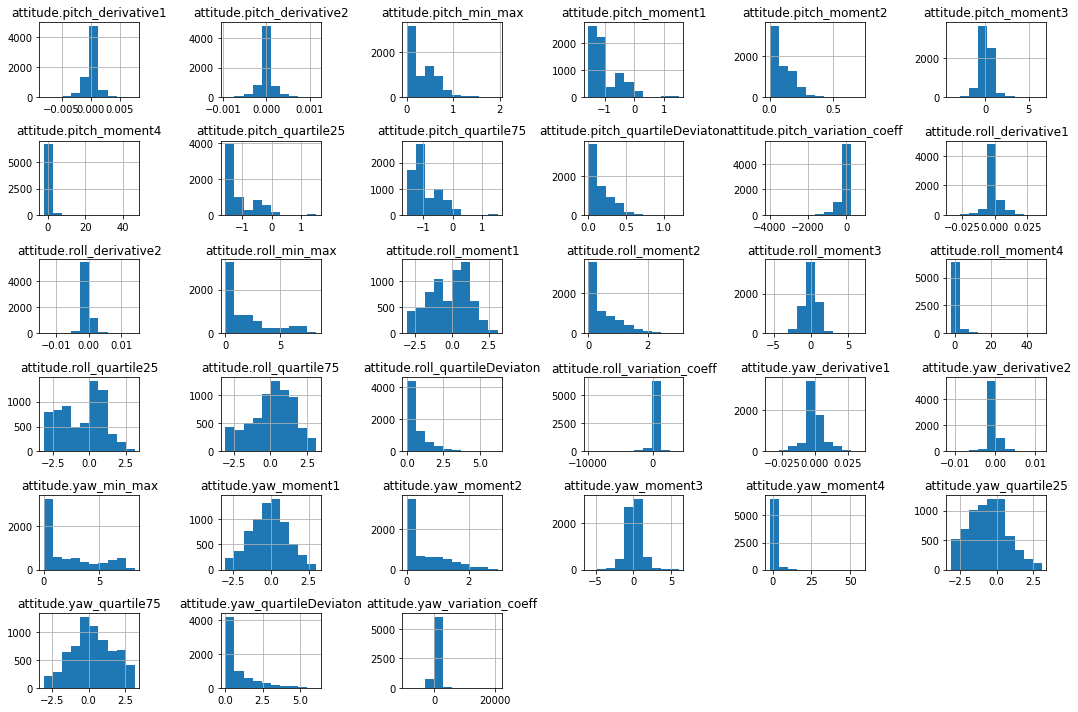

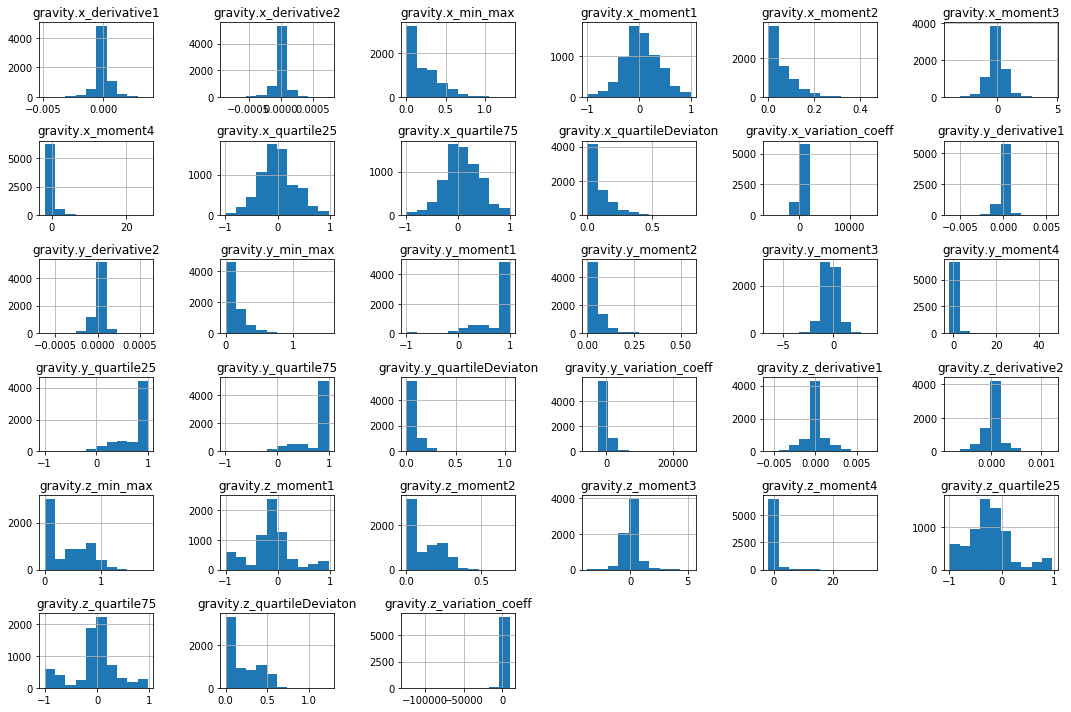

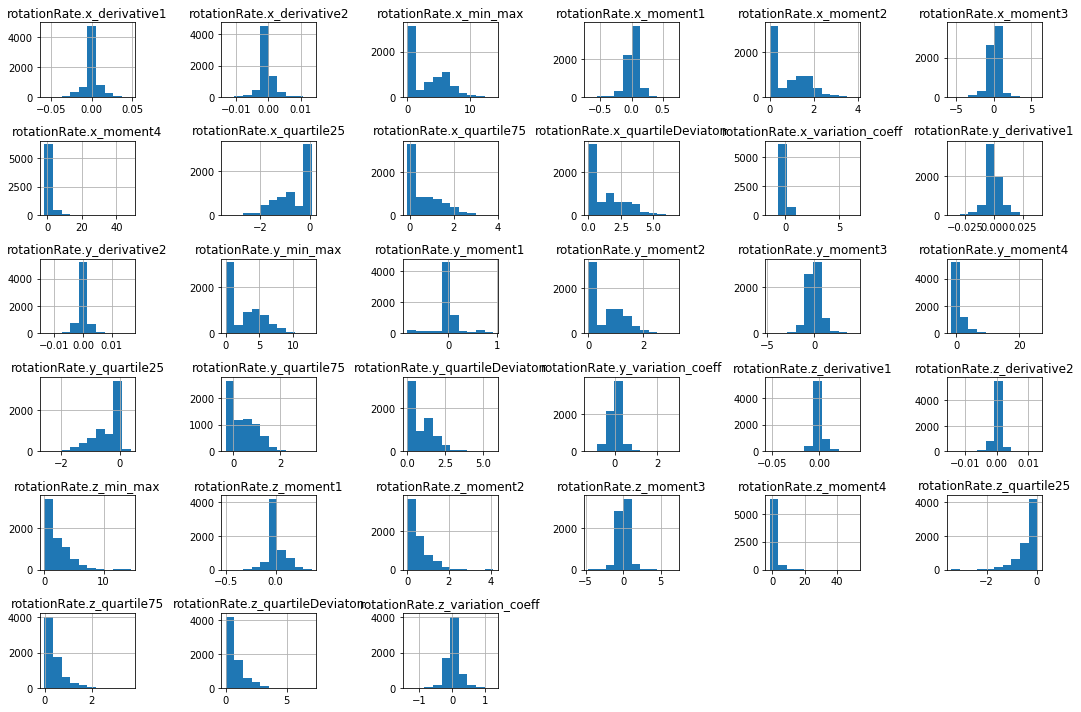

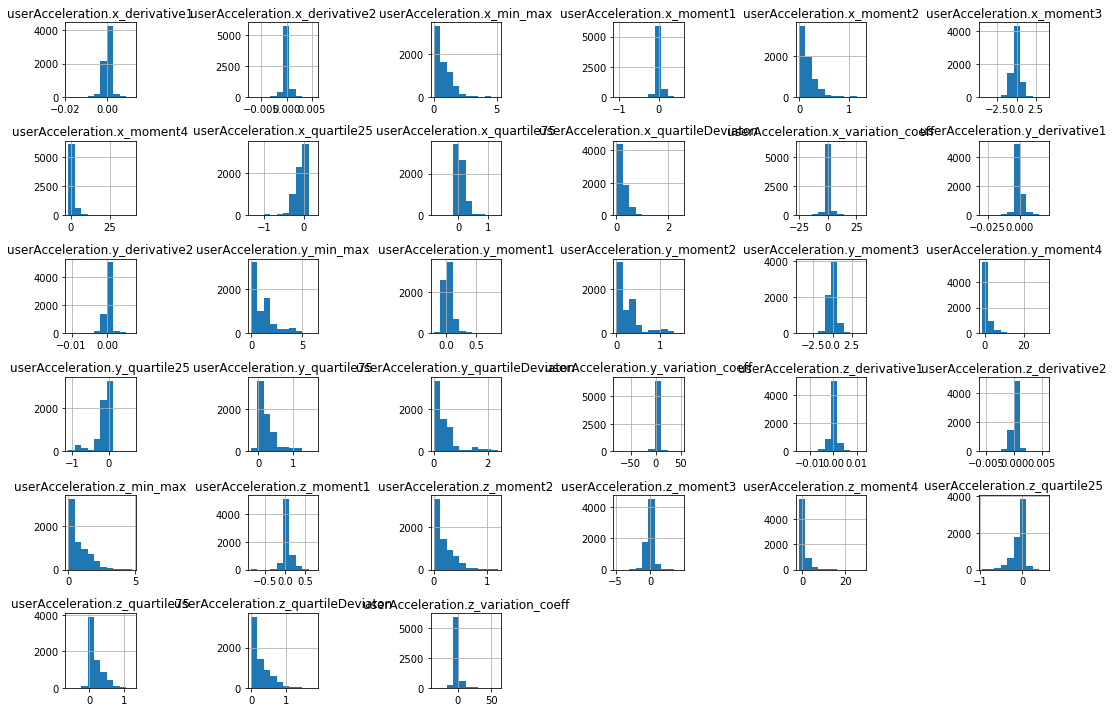

In [17]:
#For each sensor visualize the distribution of each feature using histograms 
for sensor in ['attitude', 'gravity', 'rotationRate','userAcceleration']:
    sensor_features = [] #find the feature for the specific sensor
    for c in df_features.columns:
        if sensor in c and 'window_count' not in c:
            sensor_features.append(c)
    df_features[sensor_features].hist(figsize=(15,10))
    plt.tight_layout()
    plt.show()

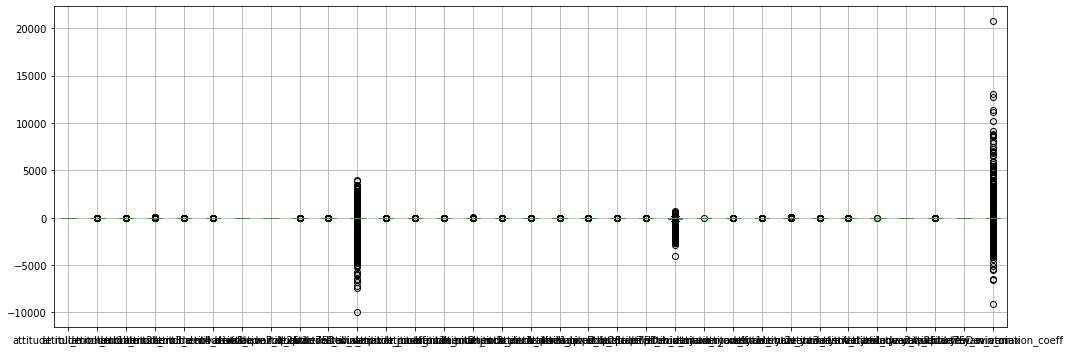

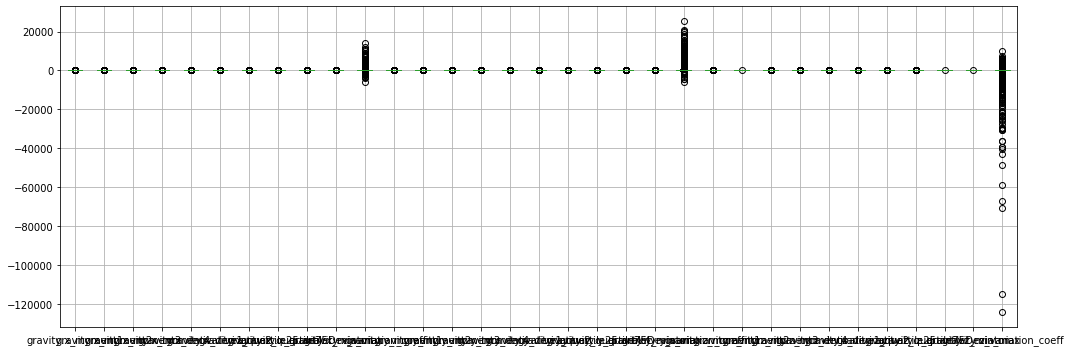

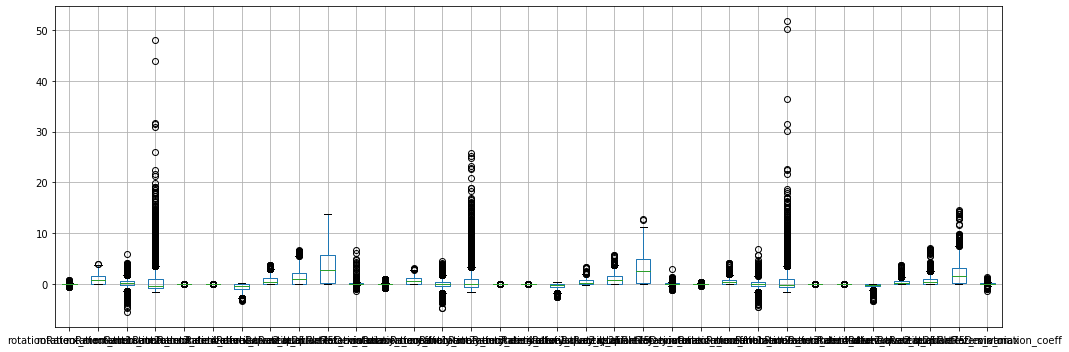

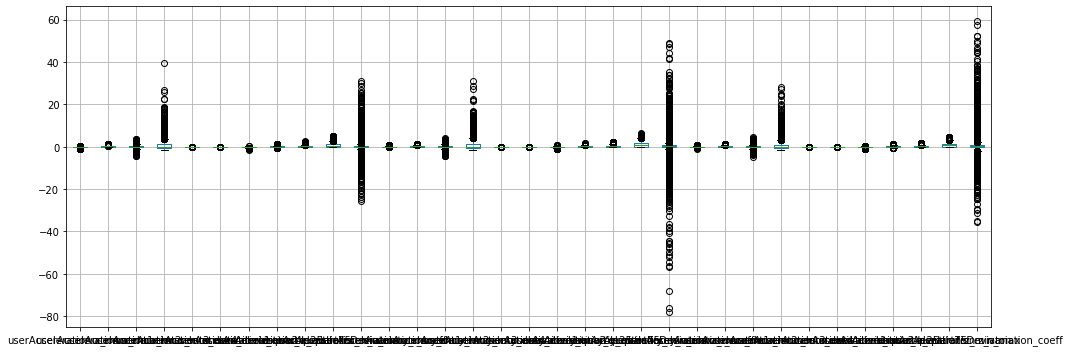

In [18]:
#For each sensor visualize the distribution of each feature using boxplots 
for sensor in ['attitude', 'gravity', 'rotationRate','userAcceleration']:
    sensor_features = [] #find the feature for the specific sensor
    for c in df_features.columns:
        if sensor in c and 'window_count' not in c:
            sensor_features.append(c)
    df_features[sensor_features].boxplot(figsize=(15,5))
    plt.tight_layout()
    plt.show()

In [23]:
df_features.columns[4:]

Index(['attitude.roll_moment1', 'attitude.roll_moment2',
       'attitude.roll_moment3', 'attitude.roll_moment4',
       'attitude.roll_derivative1', 'attitude.roll_derivative2',
       'attitude.roll_quartile25', 'attitude.roll_quartile75',
       'attitude.roll_quartileDeviaton', 'attitude.roll_min_max',
       ...
       'userAcceleration.z_moment2', 'userAcceleration.z_moment3',
       'userAcceleration.z_moment4', 'userAcceleration.z_derivative1',
       'userAcceleration.z_derivative2', 'userAcceleration.z_quartile25',
       'userAcceleration.z_quartile75', 'userAcceleration.z_quartileDeviaton',
       'userAcceleration.z_min_max', 'userAcceleration.z_variation_coeff'],
      dtype='object', length=132)

In [19]:
#Normalize the features (min-max normalization)
feature_columns = df_features.columns[4:]
df_features_norm = df_features.copy()
df_features_norm[feature_columns] = (df_features_norm[feature_columns]  - df_features_norm[feature_columns].min()) / (df_features_norm[feature_columns].max()-df_features_norm[feature_columns].min()) 

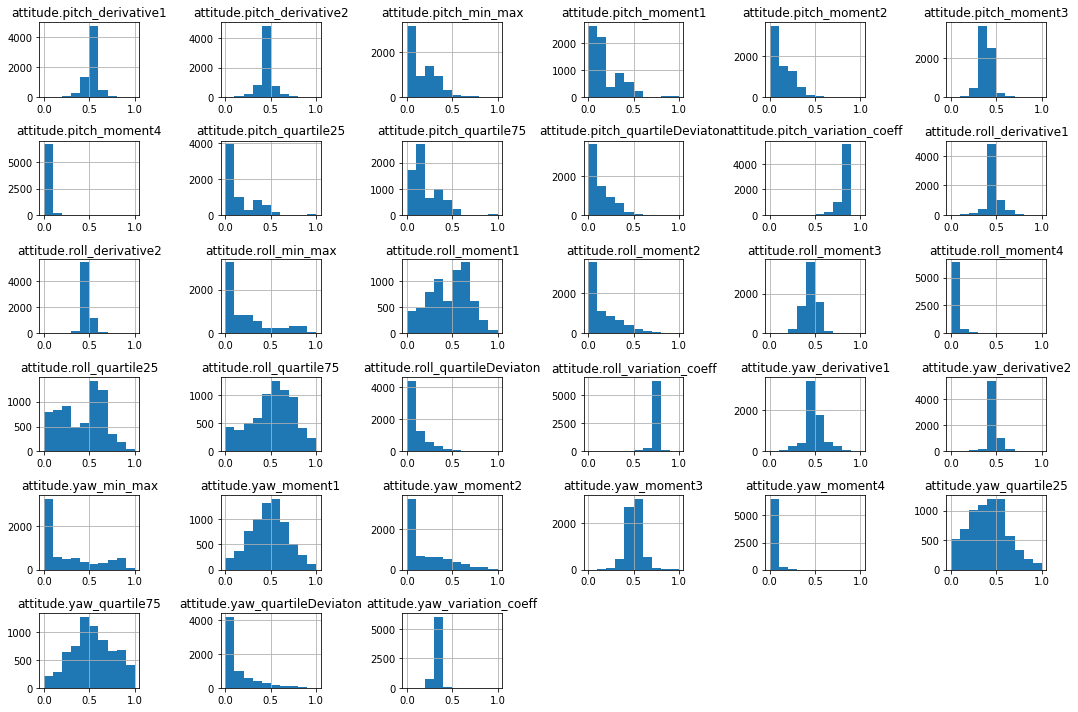

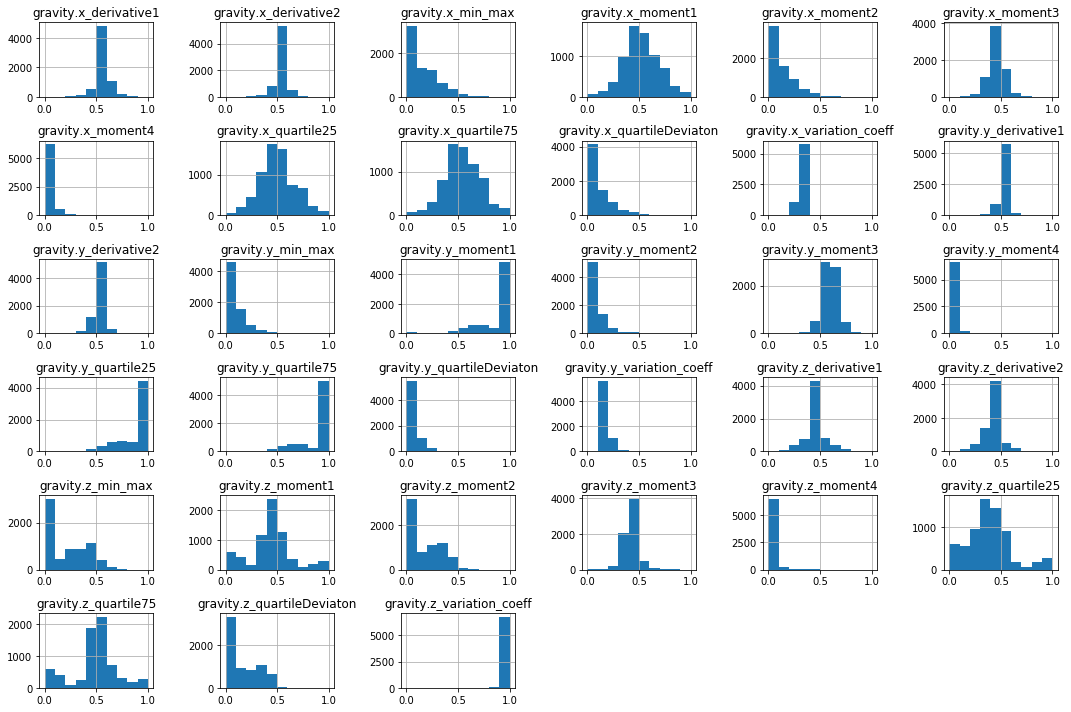

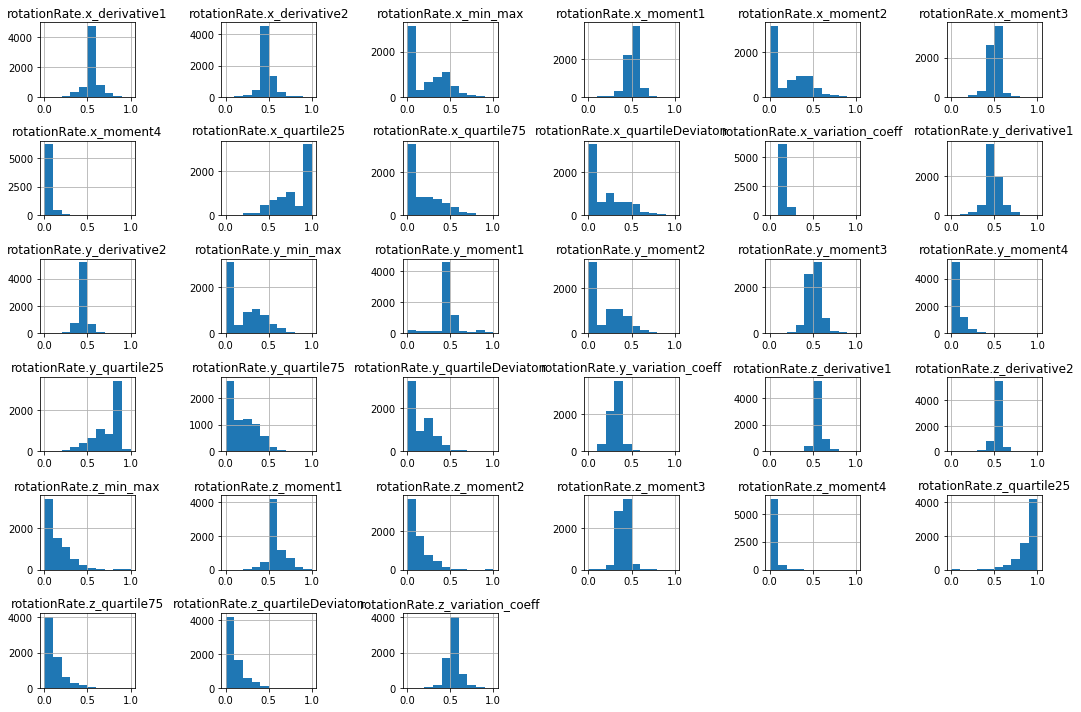

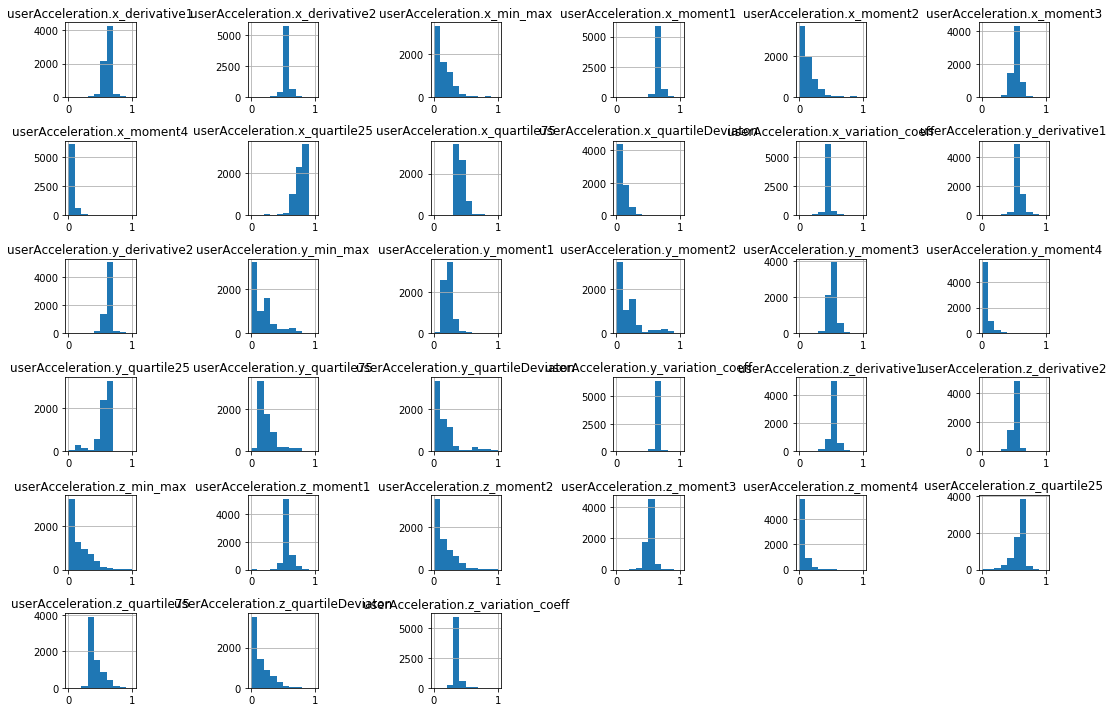

In [26]:
#For each sensor visualize the distribution of each feature using histograms 
for sensor in ['attitude', 'gravity', 'rotationRate','userAcceleration']:
    sensor_features = [] #find the feature for the specific sensor
    for c in df_features.columns:
        if sensor in c and 'window_count' not in c:
            sensor_features.append(c)
    df_features_norm[sensor_features].hist(figsize=(15,10))
    plt.tight_layout()
    plt.show()

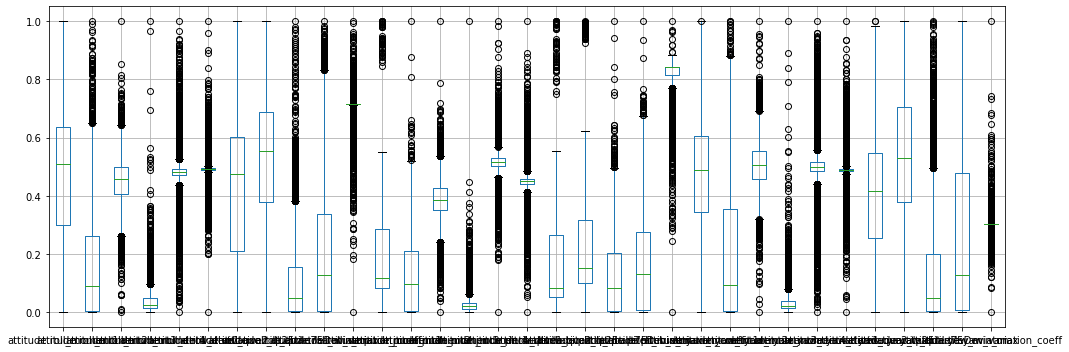

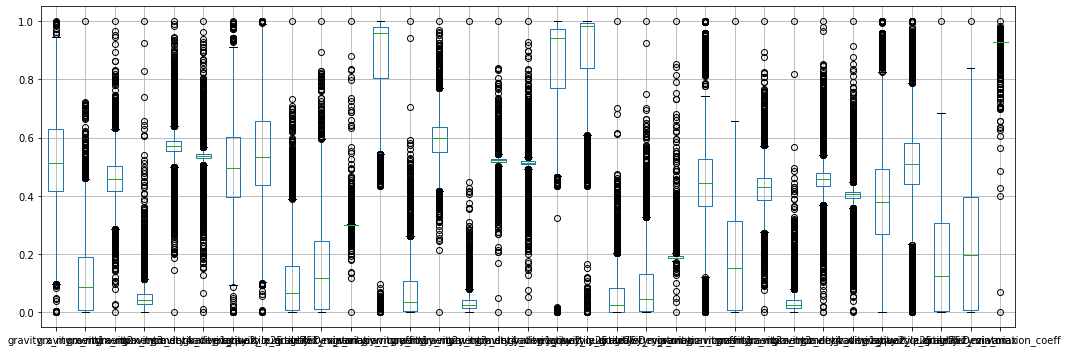

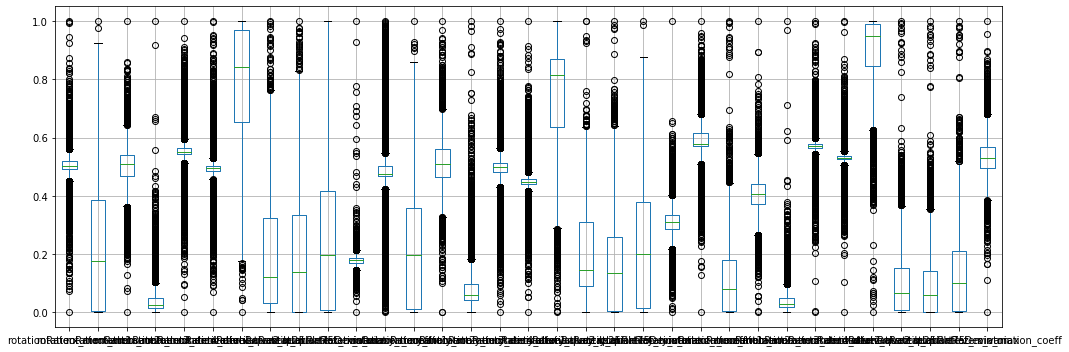

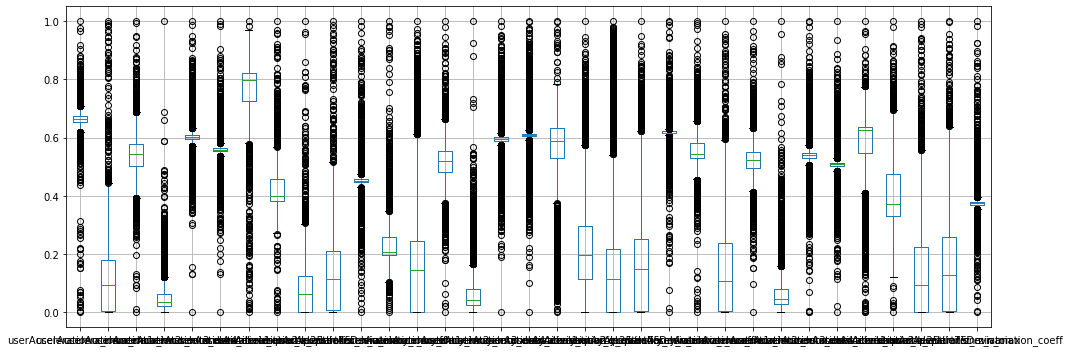

In [25]:
#For each sensor visualize the distribution of each feature using boxplots 
for sensor in ['attitude', 'gravity', 'rotationRate','userAcceleration']:
    sensor_features = [] #find the feature for the specific sensor
    for c in df_features.columns:
        if sensor in c and 'window_count' not in c:
            sensor_features.append(c)
    df_features_norm[sensor_features].boxplot(figsize=(15,5))
    plt.tight_layout()
    plt.show()

### 3.1. TO DOs
1. How would you parallelize the feature-extraction process?
2. How did the normalization influence the histograms? What about the boxplots?
3. The function "get_statistical_features" calculates only statistical (time-domain features) features. How would you calculate frequency-domain features?

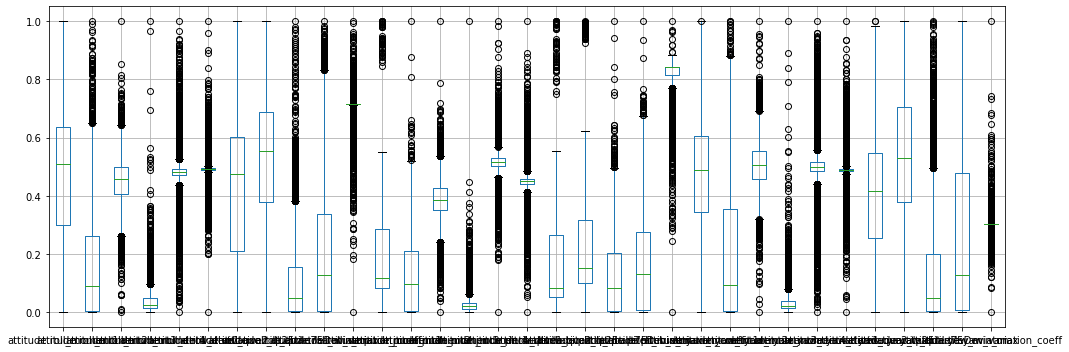

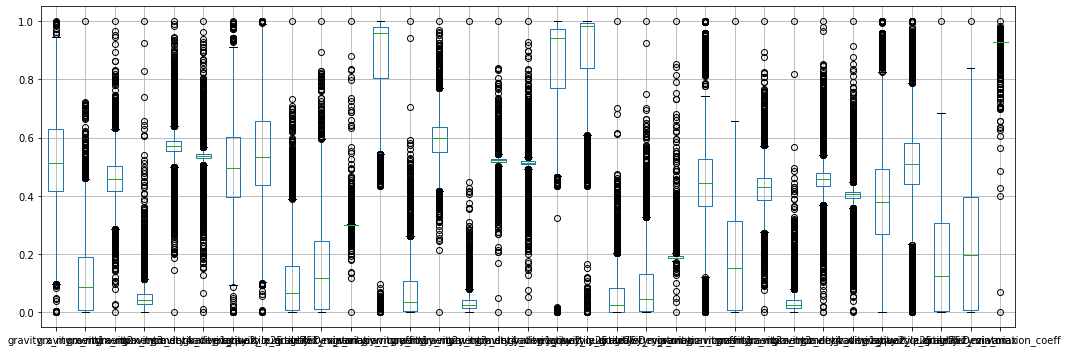

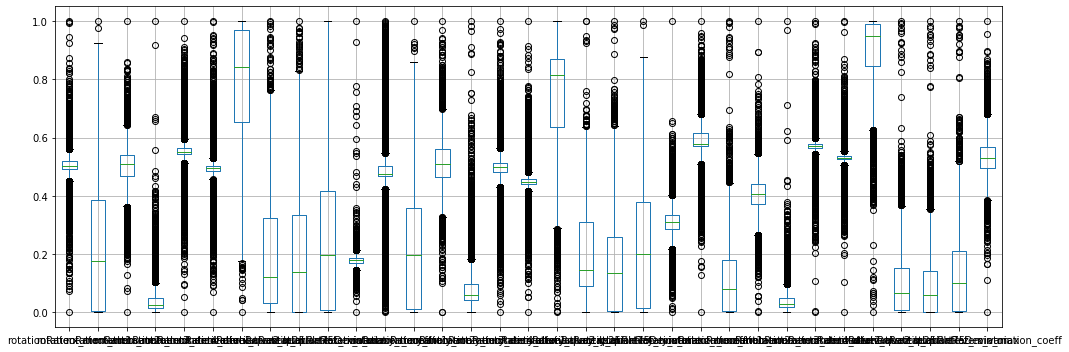

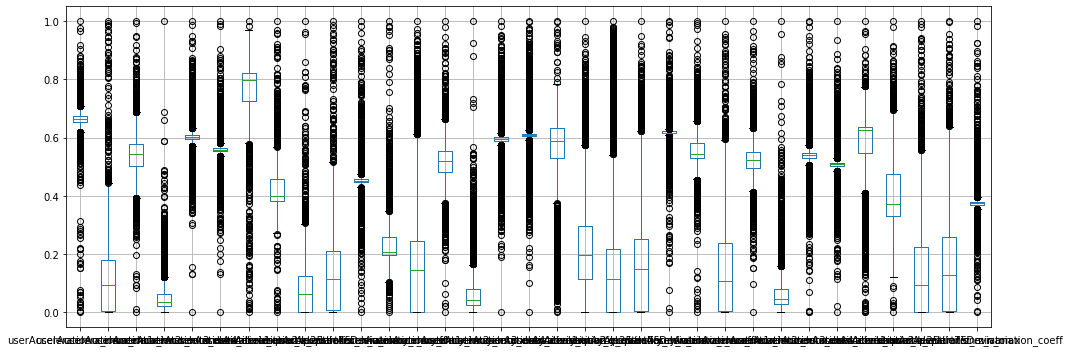

In [27]:
#For each sensor visualize the distribution of each feature using boxplots 
for sensor in ['attitude', 'gravity', 'rotationRate','userAcceleration']:
    sensor_features = [] #find the feature for the specific sensor
    for c in df_features.columns:
        if sensor in c and 'window_count' not in c:
            sensor_features.append(c)
    df_features_norm[sensor_features].boxplot(figsize=(15,5))
    plt.tight_layout()
    plt.show()

## 4. Machine learning evaluation and model building

- split the data (features) on training and test subsets using a random 70%-30% split.
- split the data (features) on training and test subsets using an ordered 70%-30% split.
- build a simple decision tree model for activity recognition and comapre its results using the two splits
- visualize the model

In [28]:
#helper functions for calculating machine learning evaluation scores
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
def full_report(Y,pred_Y):
    print('Confusion matrix')
    print('Rows - true label')
    print('Columns - predicted label')

    labels = ['dws', 'ups', 'wlk', 'jog', 'std', 'sit']
    conf_mat = confusion_matrix(Y,pred_Y)
    cr = classification_report(Y,pred_Y)
    acc = accuracy_score(Y,pred_Y)
    print(labels)
    print(conf_mat)
    print()
    print(cr)
    print("Accuracy:",acc)
    
    return

In [29]:
#evaluation using random split
from sklearn.model_selection import train_test_split
from sklearn import tree
X_train, X_test, y_train, y_test = train_test_split(df_features_norm[feature_columns], 
                                                    df_features_norm.label, 
                                                    test_size=0.3, 
                                                    random_state=42,
                                                   shuffle=True)
clf = tree.DecisionTreeClassifier(max_depth=5)#initialize the algorithm
clf.fit(X_train,y_train)#train the model
predictions = clf.predict(X_test) #predict the test data
full_report(y_test,predictions) # show evaluaton results for the test data

Confusion matrix
Rows - true label
Columns - predicted label
['dws', 'ups', 'wlk', 'jog', 'std', 'sit']
[[165  14   8   0   0   1]
 [ 15 178  34   1   0   0]
 [ 15  30 471   0   0   0]
 [  0   0   7 194   0   0]
 [  0   1   0   0 449   2]
 [  0   0   0   0   2 479]]

              precision    recall  f1-score   support

         0.0       0.85      0.88      0.86       188
         1.0       0.80      0.78      0.79       228
         2.0       0.91      0.91      0.91       516
         3.0       0.99      0.97      0.98       201
         4.0       1.00      0.99      0.99       452
         5.0       0.99      1.00      0.99       481

    accuracy                           0.94      2066
   macro avg       0.92      0.92      0.92      2066
weighted avg       0.94      0.94      0.94      2066

Accuracy: 0.9370764762826719


In [30]:
#evaluation using ordered split
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, y_train, y_test = train_test_split(df_features_norm[feature_columns], 
                                                    df_features_norm.label, 
                                                    test_size=0.3, 
                                                    random_state=42,
                                                   shuffle=False)

clf = tree.DecisionTreeClassifier(max_depth=5)#initialize the algorithm
clf.fit(X_train,y_train)#train the model
predictions = clf.predict(X_test) #predict the test data
full_report(y_test,predictions) # show evaluaton results for the test data

Confusion matrix
Rows - true label
Columns - predicted label
['dws', 'ups', 'wlk', 'jog', 'std', 'sit']
[[170   6  16   0   0   0]
 [  6 182  49   0   0   0]
 [ 70  52 382   0   6   0]
 [  2  19   0 179   0   0]
 [  0   1   0   0 470   0]
 [  0   0   0   0  41 415]]

              precision    recall  f1-score   support

         0.0       0.69      0.89      0.77       192
         1.0       0.70      0.77      0.73       237
         2.0       0.85      0.75      0.80       510
         3.0       1.00      0.90      0.94       200
         4.0       0.91      1.00      0.95       471
         5.0       1.00      0.91      0.95       456

    accuracy                           0.87      2066
   macro avg       0.86      0.87      0.86      2066
weighted avg       0.88      0.87      0.87      2066

Accuracy: 0.8702807357212003


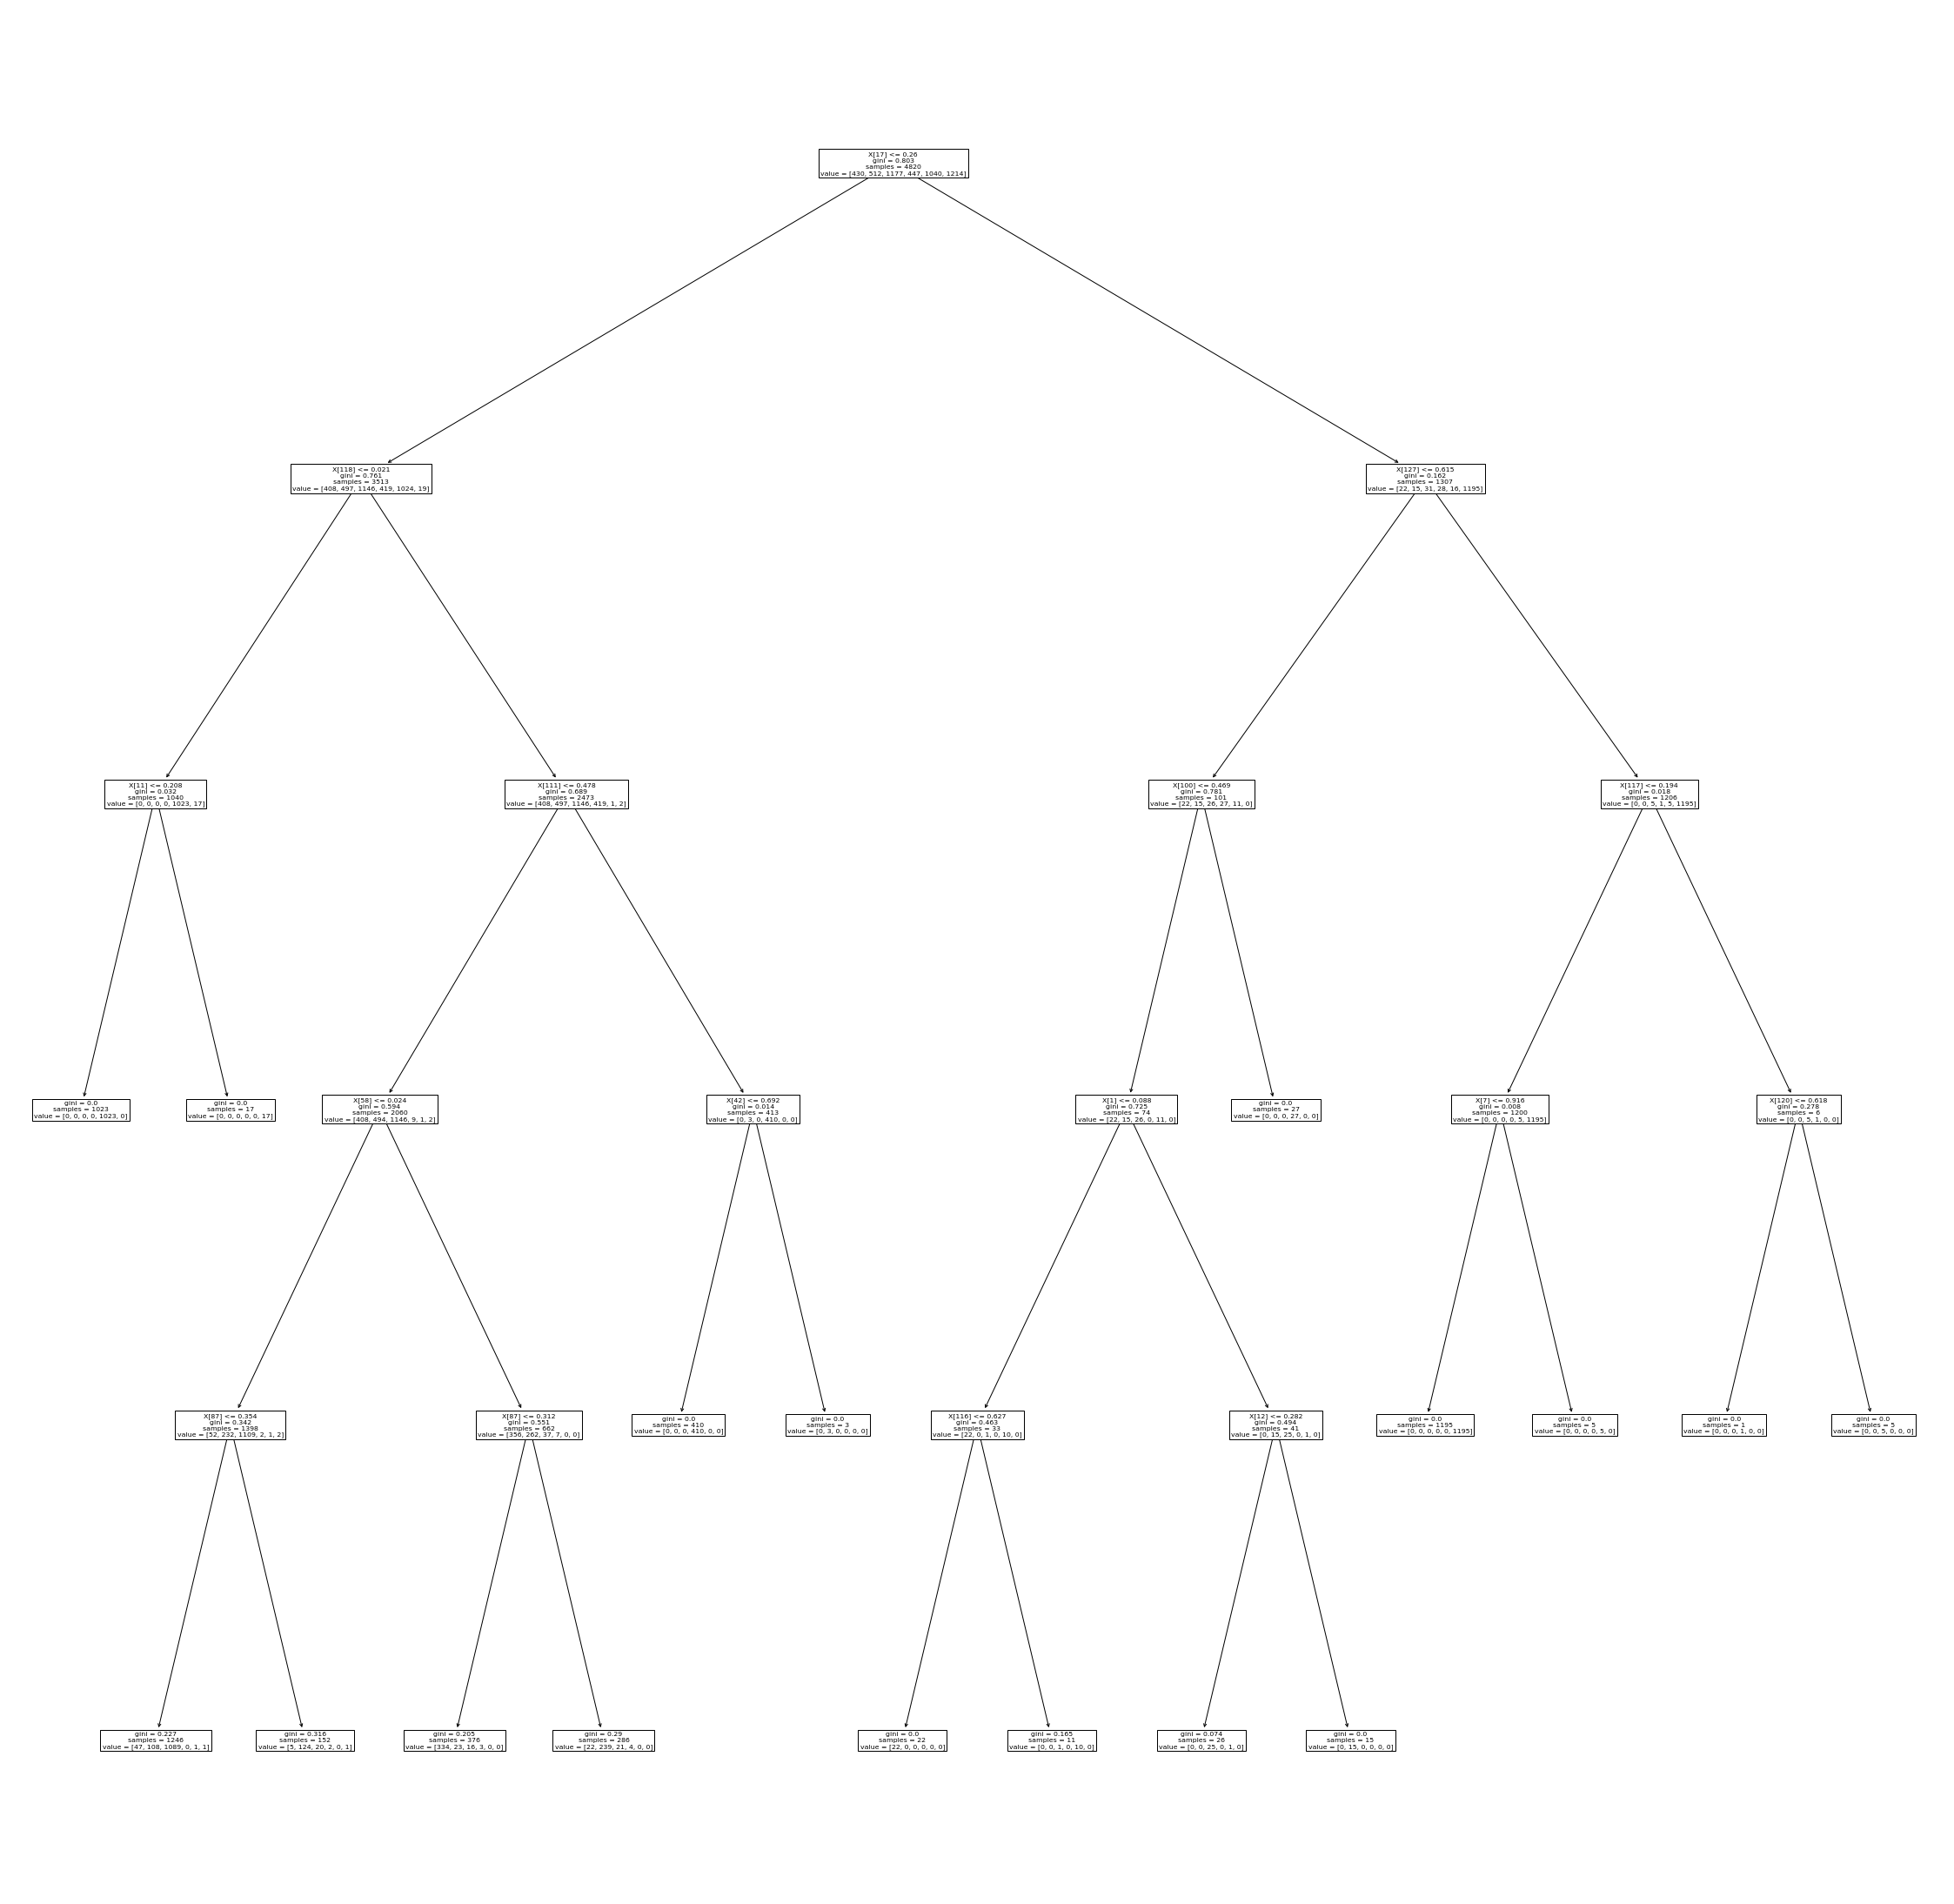

In [33]:
#model visualization
plt.figure(figsize=(40,40))
tree.plot_tree(clf)  
plt.show()

In [32]:
#if then else representataion based on https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree
from sklearn.tree import _tree
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
#     print ("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print ("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print ("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print ("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)
    
tree_to_code(clf,feature_columns)

  if attitude.pitch_quartile25 <= 0.2600482553243637:
    if userAcceleration.y_quartileDeviaton <= 0.021327288821339607:
      if attitude.pitch_moment1 <= 0.20832166820764542:
        return [[   0.    0.    0.    0. 1023.    0.]]
      else:  # if attitude.pitch_moment1 > 0.20832166820764542
        return [[ 0.  0.  0.  0.  0. 17.]]
    else:  # if userAcceleration.y_quartileDeviaton > 0.021327288821339607
      if userAcceleration.y_moment2 <= 0.47780001163482666:
        if gravity.z_moment4 <= 0.023554915562272072:
          if rotationRate.y_variation_coeff <= 0.3540169447660446:
            return [[4.700e+01 1.080e+02 1.089e+03 0.000e+00 1.000e+00 1.000e+00]]
          else:  # if rotationRate.y_variation_coeff > 0.3540169447660446
            return [[  5. 124.  20.   2.   0.   1.]]
        else:  # if gravity.z_moment4 > 0.023554915562272072
          if rotationRate.y_variation_coeff <= 0.3124969154596329:
            return [[334.  23.  16.   3.   0.   0.]]
          else

### 4.1 TO DOs
- Which classes are frequently mixed by the classifier?
- How would you reimplement the decision tree model on an android device?

### Further reading

- Normalization: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
- General feature extractor for time-series (in most cases, expert defiend features are better. Always check related work for your specific machine learning problem): https://tsfresh.readthedocs.io/en/latest/index.html
- Machine learning (scikit-learn): https://scikit-learn.org/stable/tutorial/basic/tutorial.html
-  More info about the dataset and analysis performed over it:
http://doi.acm.org/10.1145/3302505.3310068 (Malekzadeh et al. "Mobile sensor data anonymization", Proceedings of the International Conference on Internet of Things Design and Implementation, 2019).

Add frequency features and: Update get_statistical_features to calculate statistics + spectrogram features
* What is the dominant frequency
*


Run a leave-one-subject out evaluation